In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os, glob
import copy
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from gpuinfo import GPUInfo as gpu
import pickle as pk
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
from matplotlib import cm
from sklearn import preprocessing
import cv2
from IPython.display import clear_output
from sys import getsizeof
from PIL import Image
import shutil
import sys
import math
import ctcdecode

In [2]:
class dataLoader():
    
    def __init__(self, directory, batch_size):
        self.directory = directory
        self.batch_size = batch_size
        self.pwd = os.getcwd()
        self.getFileList()
        self.getBatches()
        self.currentbatch = 0
        
    def getFileList(self):
        filenames = []
        os.chdir(self.directory)
        for f in glob.glob("*.xml"):
            tree = ET.parse(f)
            root = tree.getroot()
            name = root.findall('filename')
            filenames.append(name[0].text)
        self.filenames = filenames
        return

    def getBatches(self):
        batch_size = self.batch_size
        total = len(self.filenames)
        batches = []
        for i in range(0, total, batch_size):
            batch = self.filenames[i: i + batch_size]
            batches.append(batch)
        os.chdir(self.pwd)
        self.batches = batches
        return
    
    def hasNext(self):
        if self.currentbatch < len(self.batches):
            return True
        else:
            self.reInitialize()
            os.chdir(self.pwd)
            return False
        
    def reInitialize(self):
        self.currentbatch = 0
        return
    
    def processedDataStatus(self):
        return int(self.currentbatch*self.batch_size/len(self.filenames)*100)
    
    def next(self):
        
        if self.currentbatch < len(self.batches):
            data, labels = self.readData(self.batches[self.currentbatch])
            self.currentbatch = self.currentbatch + 1
            return data, labels, self.currentbatch - 1
        else:
            print('epoch complete', self.pwd)
            os.chdir(self.pwd)
            return False
        
    def readData(self, batch):
        data = []
        labels = []
        os.chdir(self.directory)
        trans = transforms.Compose([transforms.ToTensor()])
        
        for filename in batch:
            img  = cv2.imread(filename+'.jpg')
            img = cv2.resize(img, (1500, 112))
            #img = cv2.flip(img, 1)
            #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_pil = Image.fromarray(img)
            img = trans(img_pil)
            tree = ET.parse(filename+'.xml')
            root = tree.getroot()
            name = root.findall('object/name')
            label = name[0].text
            if type(label) == str:
                labels.append(label)
                data.append(img)
        return torch.stack(data), labels

dataloader = dataLoader('/home/talha/MSDS/Deep Learning Project/data/test', 5)

In [4]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.cnn = nn.Sequential(
            
            #"""CONV 1"""
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #"""CONV 2""" 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #"""CONV 3""" 
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            #"""CONV 4""" 
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=2),
            
            #"""CONV 5""" 
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),            
            
            #"""CONV 6""" 
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(2,1), stride=2),
            
            #"""CONV 7""" 
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
        )

        self.lstm1 = nn.LSTM(input_size = 14, num_layers = 1, hidden_size = 22, bidirectional = True, batch_first = True)
        self.output = nn.LogSoftmax(2)

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn(x)
        
        tt = []
        for t in x:
            t1 = t.mean(dim = 0)
            tt.append(t1.transpose(0,1))
        
        x = torch.stack(tt, 0)
        x = self.lstm1(x)
        s = self.output(x[0])
        
        return x,s
    

In [5]:
class ctcLoss(nn.Module):
    def __init__(self):
        super(ctcLoss, self).__init__()
        self.criterion = nn.CTCLoss()
        self.charlist = self.getCharList()
        
    def getCharList(self):
        f = open('/home/talha/MSDS/Deep Learning Project/charList.txt', 'r')
        lis = f.read().split()
        lis.append(' ')
        return lis
    
    def mapLabels(self, labels):
        labelmapping = []
        label_length = []
        for label in labels:
            c= []
            if type(label) == str:
                for char in label:
                    c.append(self.charlist.index(char)) if char in self.charlist else c.append(1)

                labelmapping.append(torch.tensor(c))
                label_length.append(len(c))
            else:
                print('*****************',label)
                print(labels)
                print(type(label))
        return labelmapping, label_length
    
    def forward(self, x, target, dire= True):
        labelmap, label_length = self.mapLabels(target)
#         print(x.shape)
        x = x.reshape(x.shape[1], x.shape[0], x.shape[2])
        input_length = [x.shape[0]] * x.shape[1]
        labelmapping = torch.cat(labelmap)
        return self.criterion(x, labelmapping, torch.tensor(input_length), torch.tensor(label_length)), labelmap


In [6]:
model = Net()
model.to('cuda:0')
optimizer = optim.SGD(model.parameters(), 0.001, momentum= 0.9)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
model.train()
model.load_state_dict(torch.load('/home/talha/MSDS/Deep Learning Project/model50.pth'))

<All keys matched successfully>

In [7]:
def binary_accuracy(preds, y):
    preds = list(preds.cpu().detach().numpy())
    y = list(y.cpu().detach().numpy())
    if len(y) < len(preds):
        preds = preds[:len(y)]
    elif len(preds) < len(y):
        y = y[:len(preds)]
    correct = 0
    for i in range(len(y)):
        if y[i] in preds:
            correct = correct + 1
    return correct/len(y)*100


def train(epochs):
    criterion = ctcLoss()
    criterion.to('cuda:0')
    last_five_loss = []
    epoch_loss = []
    epoch_accuracy = []
    for i in range(epochs):
        loss_val = []
        accuracy_val = []

        while dataloader.hasNext():
            optimizer.zero_grad()
            data, labels, currentbatch = dataloader.next()
            data = data.to('cuda:0')
            x,s = model(data)
#             print(s.shape)
            loss,labelmapping = criterion(s, labels)
#             return x,s

            decoder = ctcdecode.CTCBeamDecoder(criterion.charlist, beam_width=30,
                                           blank_id=criterion.charlist.index('_'), log_probs_input=False,
                                           num_processes=24)
            beam_results, beam_scores, timesteps, out_seq_len = decoder.decode(s)

            acc = []
            for z in range(len(beam_results)):
                acc.append(binary_accuracy(beam_results[z][0], labelmapping[z]))
            ac = int(np.mean(acc))
            accuracy_val.append(ac)
        
            sys.stdout.write("Epoch: {0}/{1}  {2} {3}% Batch: {4} Loss: {5} Accuracy:{6} \r".format(
                    i+1,
                    epochs,
                    '=' * int((dataloader.processedDataStatus()+1)/4)+'>'+ ' ' * (int((100 - dataloader.processedDataStatus())/4)), 
                    dataloader.processedDataStatus(),
                    currentbatch, 
                    loss.item(),
                    ac
                    )
                )
            if not math.isinf(loss.item()):
                loss_val.append(loss.item())
                loss.backward()
                optimizer.step()
        
        avg_epoch_loss = np.mean(loss_val)
        avg_epoch_accuracy = np.mean(accuracy_val)
        print('\nAverage Loss:', avg_epoch_loss, 'Average Accuracy:', avg_epoch_accuracy)
        epoch_loss.append(avg_epoch_loss)
        epoch_accuracy.append(avg_epoch_accuracy)
        print('\n')
    return epoch_loss, epoch_accuracy

# loss, accuracy = train(500)

# torch.save(model.state_dict(), '/home/talha/MSDS/Deep Learning Project/model.pth')

In [8]:
loss, accuracy = train(25)
# torch.save(model.state_dict(), '/home/talha/MSDS/Deep Learning Project/model50.pth')

Epoch: 1/25  =========================> 100% Batch: 106 Loss: 9.804289817810059 Accuracy:27 
Average Loss: 13.27852612343904 Average Accuracy: 36.21495327102804


Epoch: 2/25  =========================> 100% Batch: 106 Loss: 9.804288864135742 Accuracy:17 
Average Loss: 13.27847172835163 Average Accuracy: 35.76635514018692


Epoch: 3/25  =========================> 100% Batch: 106 Loss: 9.804287910461426 Accuracy:29 
Average Loss: 13.278449486349231 Average Accuracy: 36.05607476635514


Epoch: 4/25  =========================> 100% Batch: 106 Loss: 9.80428695678711 Accuracy:40  
Average Loss: 13.278426834356004 Average Accuracy: 36.074766355140184


Epoch: 5/25  =========================> 100% Batch: 106 Loss: 9.804285049438477 Accuracy:39 
Average Loss: 13.278405479181593 Average Accuracy: 35.981308411214954


Epoch: 6/25  =========================> 100% Batch: 106 Loss: 9.80428409576416 Accuracy:30  
Average Loss: 13.278385710493426 Average Accuracy: 35.205607476635514


Epoch: 7/25  ==

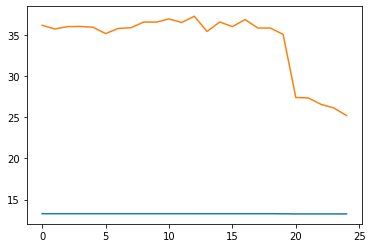

In [9]:
plt.plot(loss[:35], label = 'Loss')
plt.plot(accuracy[:35], label = 'Accuracy')

In [ ]:
loss2, accuracy2 = train(500)

Epoch: 1/500  =========================> 100% Batch: 215 Loss: inf Accuracy:37  Accuracy:23  
Average Loss: 10.676752903522589 Average Accuracy: 18.893023255813954


Epoch: 2/500  =========================> 100% Batch: 215 Loss: inf Accuracy:25 Accuracy:15   
Average Loss: 10.431845165028864 Average Accuracy: 14.851851851851851


Epoch: 3/500  =========================> 100% Batch: 215 Loss: inf Accuracy:20  Accuracy:17  
Average Loss: 10.197755549635206 Average Accuracy: 16.73611111111111


Epoch: 4/500  =========================> 100% Batch: 215 Loss: inf Accuracy:12  Accuracy:9   
Average Loss: 9.944318305472938 Average Accuracy: 10.805555555555555


Epoch: 5/500  =========================> 100% Batch: 215 Loss: inf Accuracy:7 3 Accuracy:7  
Average Loss: 9.691379777022771 Average Accuracy: 5.75


Epoch: 6/500  =========================> 100% Batch: 215 Loss: inf Accuracy:4 9 Accuracy:7  
Average Loss: 9.474025167980972 Average Accuracy: 5.50462962962963


Epoch: 7/500  ============

In [10]:
pk.dump(loss, open('val_loss.pkl', 'wb'))
pk.dump(accuracy, open('val_accuracy.pkl', 'wb'))

In [14]:
a1 = pk.load(open('accuracy1.pkl', 'rb'))
l1 = pk.load(open('loss1.pkl', 'rb'))
a10 = pk.load(open('accuracy10.pkl', 'rb'))
l10 = pk.load(open('loss10.pkl', 'rb'))
a50 = pk.load(open('accuracy50.pkl', 'rb'))
l50 = pk.load(open('loss50.pkl', 'rb'))

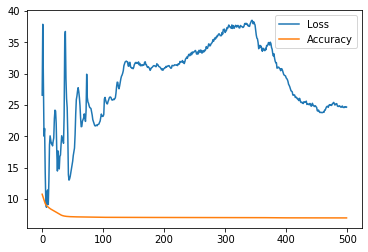

In [16]:
plt.plot(a1, label = 'Loss')
plt.plot(l1, label = 'Accuracy')
plt.legend()

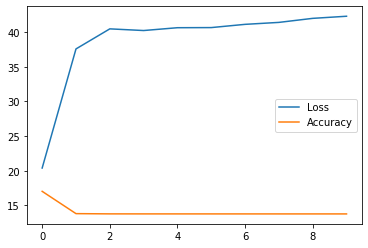

In [17]:
plt.plot(a10, label = 'Loss')
plt.plot(l10, label = 'Accuracy')
plt.legend()

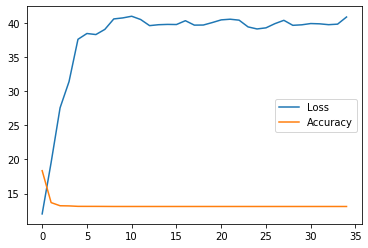

In [19]:
plt.plot(a50[:35], label = 'Loss')
plt.plot(l50[:35], label = 'Accuracy')
plt.legend()

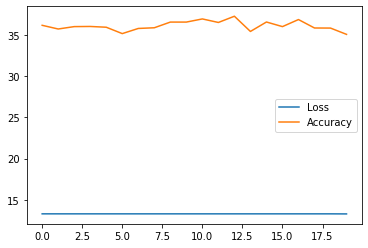

In [12]:
plt.plot(loss[:20], label = 'Loss')
plt.plot(accuracy[:20], label = 'Accuracy')
plt.legend()